# Project 06: TWITTER REAL OR NOT
## Bloc n°4 - Jedha - dsmft - Paris14
### Nicolas Hegerle

## Library imports and function definition

### <ins>Load the necessary libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt

import re

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from spacy import load
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS

nlp = load("en_core_web_sm")

### <ins>Function definition</ins>

In [2]:
def clean_text(text, stop_words, nlp, link_start = 'http'):
    """
    Pre-processes an input string for machine learning by removing any unwanted characters
     
    Arguments:
    text: the string you want to transform
    stop_words: the set of stop words you want to remove from the string
    nlp: the spacy model you want to use for lemmatisation
    link_start: string of characters representing the beginning of the links you want to remove Ex: to remove "http://t.co/rOI2NSmEJJ" pass "http"

    Operations:
    Removes all alpha numeric and double spaces from 'text'
    Replaces all double spaces by single spaces in 'text'
    Removes links starting with "link_start" before a white space or at the end of the line
    Changes all text to lower and stips white spaces at the en or beginning of a line
    Remove "stop_words" and lemmatozes "text" with "nlp"

    Output:
    The cleaned string

    Usage example:

    Given

    text = "Check these out: http://t.co/rOI2NSmEJJ http://t.co/LxTjc87KLS #nsfw"
    stop_words = spacy.lang.en.stop_words import STOP_WORDS
    nlp = load("en_core_web_sm") from spacy
    link_start = 'http'

    Returns
    
    "check nsfw"
    """


    text = ''.join(ch for ch in text if ch.isalnum() or ch == " ") #remove all non alpha-numeric characters and double spaces
    text = re.sub(r" +", " ", text) #replace all double spaces with a single space
    text = re.sub(r"{}.*?(?=\s)".format(link_start), '', text) #remove all web links followed by a space
    text = re.sub(r"{}.+$".format(link_start), '', text) #remove all web links at the end of a line
    text = text.lower().strip() #change all string to lower and remove any spaces at the beginning or end of a string
    text = " ".join([token.lemma_ for token in nlp(text) if (token.lemma_ not in stop_words) & (token.text not in stop_words)]) #lemmatise and remove stop words
    return text

## Part I: data loading and exploration

### <ins>Load the dataset and print basic stats</ins>

In [3]:
df_train = pd.read_csv("train.csv", encoding='utf8')
df_test = pd.read_csv("test.csv", encoding='utf8')

print("Train data head:")
display(df_train.head())

print("Test data head:")
display(df_test.head())


Train data head:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Test data head:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<font size = 5>
- The Test datasets contains the data on which we will perform our predictions for the 'competition' after training our model <br>
- The Train dataset contains the data that will be used to train, validate and test our model => three way split.

In [4]:
#Train dataset
print("Train dataset shape: ", df_train.shape)
print("\nTrain dataset info:")
print(df_train.info())
print("\nDescription of the train dataset:")
display(df_train.describe(include='all'))


Train dataset shape:  (7613, 5)

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Description of the train dataset:


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [5]:
#Unique ids in the dataset
print("There are {} unique ids in the dataset.".format(len(df_train.id.unique())))
print("There are {} unique locations in the dataset.".format(len(df_train.location.unique())))
print("There are {} unique keywrods for a total of 7552 in the dataset.".format(len(df_train.keyword.unique())))

There are 7613 unique ids in the dataset.
There are 3342 unique locations in the dataset.
There are 222 unique keywrods for a total of 7552 in the dataset.


<font size = 5>
- "id" feature will be discarded for training. <br>
- "keywords" might bring valuable information but will have to figure out how to use that feature. <br>
- Same for "locations".

In [6]:
#Lets find out what the most frequent class of the target is
print("Target class and frequency:")
print(df_train['target'].value_counts(normalize = True))

Target class and frequency:
0    0.57034
1    0.42966
Name: target, dtype: float64


<font size = 5>
- We are dealing with a binary classification problem where '0' = not an emergency and '1' = emergency. <br>
- Both classes are balanced (57% '0' vs 43% '1')

## Part II: Model training

### <ins>Dummy classification model</ins>

In [7]:
#Lets try a dummy model to get our baseline scores
X = df_train['id']
y = df_train['target']
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X, y)
print('Baseline accuracy score from the dummy model: ', dummy_clf.score(X, y))
print('Baseline f1-score from the dummy model: ', f1_score(y, dummy_clf.predict(X)))

Baseline accuracy score from the dummy model:  0.5703402075397347
Baseline f1-score from the dummy model:  0.0


<font size = "3"> <ins>Note:</ins> dummy model from Sklearn not necessary since a base model would get 57% accuracy by only predicting the most frequent outcome of the target which happens to be '0' i.e, not an emergency...but why not use it...<font>

### <ins>Baseline classification model using only the text data</ins>

In [8]:
# select the target and the data used for training
tweets = df_train[['text', 'target']]
tweets.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# preprocess the text data using the ```clean_text``` function
tweets['cleaned_tweets'] = tweets['text'].apply(lambda x: clean_text(x, STOP_WORDS, nlp, "http"))
display(tweets.head(25))

,text,target,cleaned_tweets
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfires pou...
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 close direc...
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,1,m hill fire wood
8,There's an emergency evacuation happening now ...,1,s emergency evacuation happen building street
9,I'm afraid that the tornado is coming to our a...,1,m afraid tornado come area


In [10]:
# split the dataset into train, val and test keeping the dataset structure
df_train, df_val = train_test_split(tweets, test_size = 0.25, random_state = 123)
df_val, df_test = train_test_split(df_val, test_size = 0.35, random_state = 123)

print("Shape of train dataset: ", df_train.shape)
print("Shape of val dataset: ", df_val.shape)
print("Shape of test dataset: ", df_test.shape)

print("\nTarget frequencies in train set: ")
print(df_train['target'].value_counts(normalize = True))
print("\nTarget frequencies in val set: ")
print(df_val['target'].value_counts(normalize = True))
print("\nTarget frequencies in test set: ")
print(df_test['target'].value_counts(normalize = True))


Shape of train dataset:  (5709, 3)
Shape of val dataset:  (1237, 3)
Shape of test dataset:  (667, 3)

Target frequencies in train set: 
0    0.568401
1    0.431599
Name: target, dtype: float64

Target frequencies in val set: 
0    0.586904
1    0.413096
Name: target, dtype: float64

Target frequencies in test set: 
0    0.556222
1    0.443778
Name: target, dtype: float64


In [11]:
# instantiate the word tokenizer to transform our words into tokens keeping all the words
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [12]:
# fit the tokenizer on the train texts
tokenizer.fit_on_texts(df_train.cleaned_tweets)
print("Number of tokens found: ", len(tokenizer.word_index))

# get the tokenized sequences for the train, val and test sets
df_train['encoded_tweets'] = tokenizer.texts_to_sequences(df_train.cleaned_tweets)
df_val['encoded_tweets'] = tokenizer.texts_to_sequences(df_val.cleaned_tweets)
df_test['encoded_tweets'] = tokenizer.texts_to_sequences(df_test.cleaned_tweets)

print("Train set:")
display(df_train.head())

print("\nVal set:")
display(df_val.head())

print("\nTest set:")
display(df_test.head())

Number of tokens found:  13037
Train set:


,text,target,cleaned_tweets,encoded_tweets
1750,Motorcyclist bicyclist injured in Denver colli...,1,motorcyclist bicyclist injure denver collision...,"[1211, 1212, 158, 988, 340, 1380, 7, 2982]"
6995,@ellenfromnowon 7-speed nexus shifter å£9! (Fo...,0,ellenfromnowon 7speed nexus shifter å9 communi...,"[4594, 4595, 4596, 4597, 4598, 843, 2983, 2984]"
5577,Landslide caused by severe rainstorm kills 3 i...,1,landslide cause severe rainstorm kill 3 italia...,"[320, 55, 161, 514, 11, 51, 4599]"
252,@KimKardashian can you please sign and share t...,0,kimkardashian sign share petition save wild ho...,"[4600, 169, 600, 913, 86, 233, 567, 2272]"
5628,y'all read 12000 Nigerian refugees repatriated...,1,read 12000 nigerian refugee repatriate cameroon,"[162, 785, 601, 186, 844, 845]"



Val set:


,text,target,cleaned_tweets,encoded_tweets
1113,@ChristophersZen @HunterLove1995 @tblack yeah ...,0,christopherszen hunterlove1995 tblack yeah man...,"[551, 19, 206, 18, 636]"
3265,Why are you engulfed by low self-image? Take t...,0,engulf low selfimage quiz,"[346, 587, 1357, 840]"
6512,We learn and grow and become stronger as we fa...,0,learn grow strong face survive trial pass thom...,"[380, 571, 916, 170, 79, 1605, 546]"
5375,I added a video to a @YouTube playlist http://...,0,add video youtube playlist panic disco miss ...,"[591, 12, 64, 1035, 92, 1430, 126, 4533, 1706,..."
6354,@whvholst @leashless And this is a structural ...,0,whvholst leashless structural problem failure ...,"[395, 763, 289, 3549, 759]"



Test set:


,text,target,cleaned_tweets,encoded_tweets
7225,Hello Twitter i need some book bloggers and in...,0,hello twitter need book blogger interview book...,"[1181, 298, 57, 409, 1069, 409, 60, 2883]"
1611,I liked a @YouTube video http://t.co/BM0QEC7Pj...,0,like youtube video eminem feat nate dogg til...,"[1, 64, 12, 1058, 693, 35]"
4838,@JakeGint the mass murder got her hot and both...,1,jakegint mass murder hot bother heart traditio...,"[113, 228, 103, 4376, 210]"
6330,VIDEO: Virgin Galactic crash: Brakes blamed: I...,1,video virgin galactic crash brake blame invest...,"[12, 822, 874, 15, 1437, 810, 344, 822, 874, 1..."
6067,150-Foot Sinkhole Opens In Lowndes County Resi...,1,150foot sinkhole open lowndes county residenti...,"[5857, 270, 419, 2524, 254, 2525, 249]"


In [13]:
# padding sequences so they all have the same length

# get the max length for padding
dataframes = [df_train, df_val, df_test]
max_pad = max([max(df['encoded_tweets'].apply(lambda x: len(x))) for df in dataframes])

train_pad = tf.keras.preprocessing.sequence.pad_sequences(df_train.encoded_tweets, padding = 'post', maxlen=max_pad)
print("Padded train set shape: ", train_pad.shape)

val_pad = tf.keras.preprocessing.sequence.pad_sequences(df_val.encoded_tweets, padding = 'post', maxlen=max_pad)
print("Padded val set shape: ", val_pad.shape)

test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_test.encoded_tweets, padding = 'post', maxlen=max_pad)
print("Padded test set shape: ", test_pad.shape)

Padded train set shape:  (5709, 25)
Padded val set shape:  (1237, 25)
Padded test set shape:  (667, 25)


In [14]:
# prepare the tensorflow datasets using tf.data.Dataset.from_tensor_slices
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, df_train.target))
val_ds = tf.data.Dataset.from_tensor_slices((val_pad, df_val.target))

# organize the datasets per batch
train_ds = train_ds.shuffle(len(train_ds)).batch(300)
val_ds = val_ds.shuffle(len(val_ds)).batch(300)

In [15]:

# define the model
embedding_dim = max_pad

vocab_size = len(tokenizer.word_index) + 1 # number of words in the vocabulary

model = tf.keras.models.Sequential([
                    Embedding(vocab_size, embedding_dim, name = "embedding", input_length=max_pad),
                    GlobalAveragePooling1D(),
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 25)            325950    
_________________________________________________________________
global_average_pooling1d (Gl (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                416       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 326,383
Trainable params: 326,383
Non-trainable params: 0
_________________________________________________________________


In [16]:
tb_callback = TensorBoard(log_dir="logs2")


cp_path = "save_model/cp-{epoch:04d}.ckpt"

cp_callback = ModelCheckpoint(
    filepath=cp_path,
    monitor='metric.name',
    save_weights_only=True,
    save_freq='epoch'
)

model.save_weights(cp_path.format(epoch=0))

2021-12-29 14:00:26.794894: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 14:00:26.794901: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 14:00:26.795082: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[tb_callback, cp_callback])

Epoch 1/30


2021-12-29 14:00:26.976129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 14:00:26.977141: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - 0s 5ms/step - loss: 0.6845 - binary_accuracy: 0.5684 - val_loss: 0.6751 - val_binary_accuracy: 0.5869
Epoch 2/30
20/20 [==============================] - 0s 2ms/step - loss: 0.6747 - binary_accuracy: 0.5684 - val_loss: 0.6663 - val_binary_accuracy: 0.5869


2021-12-29 14:00:27.022465: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 14:00:27.022474: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 14:00:27.024996: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 14:00:27.026314: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 14:00:27.029476: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs2/train/plugins/profile/2021_12_29_14_00_27

2021-12-29 14:00:27.030530: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs2/train/plugins/profile/2021_12_29_14_00_27/Nicolass-MBP.trace.json.gz
2021-12-29 14:00:27.031870: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs2/train/plugins/profile/2021_12_29_14_00_27

2021-12-29 14:00:27.031995

Epoch 3/30
20/20 [==============================] - 0s 2ms/step - loss: 0.6655 - binary_accuracy: 0.5684 - val_loss: 0.6582 - val_binary_accuracy: 0.5869
Epoch 4/30
20/20 [==============================] - 0s 2ms/step - loss: 0.6522 - binary_accuracy: 0.5724 - val_loss: 0.6460 - val_binary_accuracy: 0.5982
Epoch 5/30
20/20 [==============================] - 0s 2ms/step - loss: 0.6323 - binary_accuracy: 0.6318 - val_loss: 0.6303 - val_binary_accuracy: 0.6443
Epoch 6/30
20/20 [==============================] - 0s 2ms/step - loss: 0.6053 - binary_accuracy: 0.6667 - val_loss: 0.6097 - val_binary_accuracy: 0.6766
Epoch 7/30
20/20 [==============================] - 0s 2ms/step - loss: 0.5715 - binary_accuracy: 0.7450 - val_loss: 0.5864 - val_binary_accuracy: 0.7098
Epoch 8/30
20/20 [==============================] - 0s 2ms/step - loss: 0.5320 - binary_accuracy: 0.7877 - val_loss: 0.5612 - val_binary_accuracy: 0.7559
Epoch 9/30
20/20 [==============================] - 0s 2ms/step - loss: 0.48

In [19]:
#docs_infra: no_execute
%tensorboard --logdir logs --port=0001

UsageError: Line magic function `%tensorboard` not found.


<font size = 5>
- Val loss starts to increase around epoch 16. <br>
- We can reload the model from the checkpoint at that state.


In [20]:
# show the layers to check the weights
for layer in model.layers:
  print(layer.name, layer)

embedding <keras.layers.embeddings.Embedding object at 0x17f989430>
global_average_pooling1d <keras.layers.pooling.GlobalAveragePooling1D object at 0x17f989f10>
dense <keras.layers.core.Dense object at 0x281566b20>
dense_1 <keras.layers.core.Dense object at 0x281566e80>


In [21]:
#Print out the weights of the last Dense layer
print(model.layers[3].weights)

[<tf.Variable 'dense_1/kernel:0' shape=(16, 1) dtype=float32, numpy=
array([[-0.87761235],
       [-1.1077374 ],
       [ 1.186593  ],
       [-0.7988235 ],
       [-0.7298084 ],
       [ 1.1113573 ],
       [-0.9738524 ],
       [ 0.28683892],
       [-0.55095893],
       [-0.849572  ],
       [-1.0404971 ],
       [ 1.028631  ],
       [-0.10541636],
       [ 0.9323704 ],
       [ 0.12954219],
       [ 0.06211418]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.09340438], dtype=float32)>]


In [22]:
# evaluate the model after 30 epochs
loss, acc = model.evaluate(test_pad, df_test.target)

21/21 [==============================] - 0s 293us/step - loss: 0.5237 - binary_accuracy: 0.7856


In [23]:
# reload the weights of the model as they were at epoch 16
model.load_weights("save_model/cp-0016.ckpt")

In [24]:
#Print the weights of the model verify that they were indeed updated ans restored to their state at epoch 16
print(model.layers[3].weights)

[<tf.Variable 'dense_1/kernel:0' shape=(16, 1) dtype=float32, numpy=
array([[-0.6898739 ],
       [-0.9051994 ],
       [ 1.0047169 ],
       [-0.6097721 ],
       [-0.5354649 ],
       [ 0.9107268 ],
       [-0.79944617],
       [ 0.28706953],
       [-0.55095893],
       [-0.6784977 ],
       [-0.87214464],
       [ 0.8183246 ],
       [-0.10547903],
       [ 0.7233409 ],
       [ 0.12969962],
       [ 0.06216064]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.06305792], dtype=float32)>]


In [25]:
# re-evaluate the model to check that the accuracy is better than before
loss, acc = model.evaluate(test_pad, df_test.target)

21/21 [==============================] - 0s 278us/step - loss: 0.4536 - binary_accuracy: 0.8051


In [26]:
#Compute the F1 score for that model at epoch 16 as it is the score used for the contest

y_pred = np.where(model.predict(test_pad).flatten() > 0.5, 1, 0)
y_true = df_test.target
print("F1-score for the trained model is: ", f1_score(y_true, y_pred))
print("Accuracy for the trained model is: ", accuracy_score(y_true, y_pred))

F1-score for the trained model is:  0.7670250896057348
Accuracy for the trained model is:  0.8050974512743628


Confusion matrix on train set : 


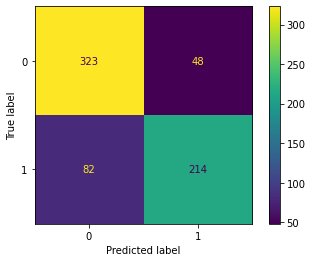

In [27]:
# Check the confusion matrices to better understanf the model
print("Confusion matrix on train set : ")
cm_train = confusion_matrix(y_true, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.show()
print()

## Part III: Make predictions on test and submit to contest

In [28]:
# load the test data and preprocess them as for model training
df_test_kag = pd.read_csv("test.csv", encoding='utf8')
df_test_kag = df_test_kag.loc[:, ['id', 'text']]
df_test_kag['cleaned_tweets'] = df_test_kag['text'].apply(lambda x: clean_text(x, STOP_WORDS, nlp, "http"))
df_test_kag['encoded_tweets'] = tokenizer.texts_to_sequences(df_test_kag.cleaned_tweets)

# check that the max sequence length is shorter than 25
max_seq_l = max(df_test_kag['encoded_tweets'].apply(lambda x : len(x)))
if  max_seq_l < 25:
    df_test_kag_pad = tf.keras.preprocessing.sequence.pad_sequences(df_test_kag.encoded_tweets, padding = 'post', maxlen=max_pad)
else:
    print(f"Max sequence length is {max_seq_l} which is greater than {max_pad}")


In [29]:
# print a few lines to check
print("First lines of the transformed test dataframe:")
display(df_test_kag.head())

print("Padded text sequenced for prediction:")
print(df_test_kag_pad[:5])

First lines of the transformed test dataframe:


,id,text,cleaned_tweets,encoded_tweets
0,0,Just happened a terrible car crash,happen terrible car crash,"[204, 1424, 46, 15]"
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[151, 176, 866, 89, 322, 1029]"
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[107, 2, 420, 2880, 2075, 365, 86]"
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,"[368, 239, 71]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[353, 530, 11, 8701, 440, 1080]"


Padded text sequenced for prediction:
[[ 204 1424   46   15    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 151  176  866   89  322 1029    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 107    2  420 2880 2075  365   86    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 368  239   71    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 353  530   11 8701  440 1080    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [30]:
df_test_kag['model_preds'] = model.predict(df_test_kag_pad)
df_test_kag['target'] = df_test_kag['model_preds'].apply(lambda x: 1 if x >= 0.5 else 0)
display(df_test_kag.head())

,id,text,cleaned_tweets,encoded_tweets,model_preds,target
0,0,Just happened a terrible car crash,happen terrible car crash,"[204, 1424, 46, 15]",0.630260,1
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[151, 176, 866, 89, 322, 1029]",0.552399,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[107, 2, 420, 2880, 2075, 365, 86]",0.816260,1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,"[368, 239, 71]",0.490171,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[353, 530, 11, 8701, 440, 1080]",0.932655,1


In [31]:
# get the predictions and ids for submission
predictions = df_test_kag[['id', 'target']]
display(predictions.head())

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [32]:
# save the predictions to a csv file for submission
predictions.to_csv('submission.csv', header = True, index = False)

<font size = 5>

## Score and next stpes
- ranked 323 out of 888 participants with score of 0.80294   
- improve text processing => twitter is a 'special' language   
- improve neural network with specific text processing RNNs but risk of increasing overfit
- add in more features for model training
- Word2Vec instead of Embedding?

</font>